# You're counting your parameters wrong

Notebook of examples used in [this post on the local learning coefficient](https://www.lesswrong.com/posts/6g8cAftfQufLmFDYT/you-re-counting-your-parameters-wrong).

In [190]:
from typing import List, Callable, Optional, Tuple, Union

import numpy as np
import torch as t
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import animation, cm, cbook
import seaborn as sns
import scipy

from tqdm.notebook import tqdm

sns.set_style('whitegrid')

In [171]:
NumPoints = Union[int, Tuple[int, int]]

def get_U_contour(U: Callable[[np.ndarray], np.ndarray], zlim=1., xlim=(-1, 1), ylim=(-1, 1), num_points: NumPoints=1000):
    """
    Yields contours for a given potential function U: [x, y] -> z
    """
    if not isinstance(num_points, tuple):
        num_points = (num_points, num_points)

    x = np.linspace(xlim[0], xlim[1], num_points[0])
    y = np.linspace(ylim[0], ylim[1], num_points[1])
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = U(np.array([X[i, j], Y[i, j]]))

            if zlim and Z[i, j] > zlim:
                Z[i, j] = np.nan

    return X, Y, Z

def get_stationary_dist_contour(U: Callable[[np.ndarray], np.ndarray], zlim=1., xlim=(-1, 1), ylim=(-1, 1), num_points: NumPoints=1000, beta=1.):
    if not isinstance(num_points, tuple):
        num_points = (num_points, num_points)

    x = np.linspace(xlim[0], xlim[1], num_points[0])
    y = np.linspace(ylim[0], ylim[1], num_points[1])
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = np.exp(-beta * U(np.array([X[i, j], Y[i, j]])))

            if zlim and Z[i, j] > zlim:
                Z[i, j] = np.nan

    return X, Y, Z

In [289]:
def plot_U_3D(U: Callable[[np.ndarray], np.ndarray], zlim=1., xlim=(-1, 1), ylim=(-1, 1), num_points: NumPoints =1000, ax: Optional[plt.Axes] = None, title: str = "$U(x)$", **kwargs):
    X, Y, Z = get_U_contour(U=U, zlim=zlim, xlim=xlim, ylim=ylim, num_points=num_points)

    # In 3D
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(X, Y, Z, **kwargs)

    if zlim:
        ax.set_zlim(0, zlim)

    ax.set_title(title)
    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")
    
    return ax


def plot_U_3D_cap(U: Callable[[np.ndarray], np.ndarray], zlim=1., xlim=(-1, 1), ylim=(-1, 1), num_points: NumPoints =1000, ax: Optional[plt.Axes] = None, title: str = "$U(x)$", **kwargs):
    X, Y, Z = get_U_contour(U=U, zlim=zlim, xlim=xlim, ylim=ylim, num_points=num_points)

    # In 3D
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

    z_cover = np.where(Z >= zlim, Z, zlim)
    z_cover = np.where(Z <= zlim, z_cover, np.nan)

    ax.plot_surface(X, Y, z_cover, **kwargs)

    if zlim:
        ax.set_zlim(0, zlim)

    ax.set_title(title)
    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")
    
    return ax

def plot_U_3D_covered(U: Callable[[np.ndarray], np.ndarray], zlim=1., xlim=(-1, 1), ylim=(-1, 1), num_points: NumPoints=1000, ax: Optional[plt.Axes] = None, title: str = "$U(x)$", bulk_alpha=1., **kwargs):
    X, Y, Z = get_U_contour(U=U, zlim=zlim, xlim=xlim, ylim=ylim, num_points=num_points)

    # In 3D
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

    z_cover = np.where(Z >= zlim, Z, zlim)
    z_cover = np.where(Z <= zlim, z_cover, np.nan)

    ax.plot_surface(X, Y, Z, alpha=bulk_alpha, **kwargs)
    ax.plot_surface(X, Y, z_cover, **kwargs)

    if zlim:
        ax.set_zlim(0, zlim)

    ax.set_title(title)
    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")
    
    return ax

def plot_stationary_dist_3D(U: Callable[[np.ndarray], np.ndarray], zlim=1., xlim=(-1, 1), ylim=(-1, 1), num_points: NumPoints=1000, ax: Optional[plt.Axes] = None, title: str = r"$\exp\{-\beta U(x)\}$", **kwargs):
    X, Y, Z = get_stationary_dist_contour(U=U, zlim=zlim, xlim=xlim, ylim=ylim, num_points=num_points)

    # In 3D
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(X, Y, Z, **kwargs)

    # Max height = 1
    ax.set_zlim(0, zlim)

    ax.set_title(title)
    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")
    
    return ax

def isolate_contour(ax):
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_zticks([])
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_zlabel("")
    ax.set_title("")

    # Change color of the axis plane
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # Hide the lines
    ax.xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

    ax.axis('off')


CMAP = sns.color_palette("muted", as_cmap=True)
PRIMARY, SECONDARY, TERTIARY = CMAP[:3]

def plot_U_volume_growth(U: Callable[[np.ndarray], np.ndarray], zlims: List[float], **kwargs):
    num_subplots = len(zlims)
    fig, axes = plt.subplots(1, num_subplots, figsize=(20, 10), subplot_kw={'projection': '3d'})

    for ax, zlim in zip(axes, zlims):
        plot_U_3D_covered(lambda x: U(x) + 0.001, ax=ax, zlim=zlim, linewidth=0., color=PRIMARY, bulk_alpha=0.5, **kwargs)
        plot_U_3D(U, ax=ax, zlim=1., linewidth=0., alpha=0.125, color=SECONDARY, **kwargs)
        isolate_contour(ax)

    return fig, axes

(<Figure size 2000x1000 with 5 Axes>,
 array([<Axes3D: >, <Axes3D: >, <Axes3D: >, <Axes3D: >, <Axes3D: >],
       dtype=object))

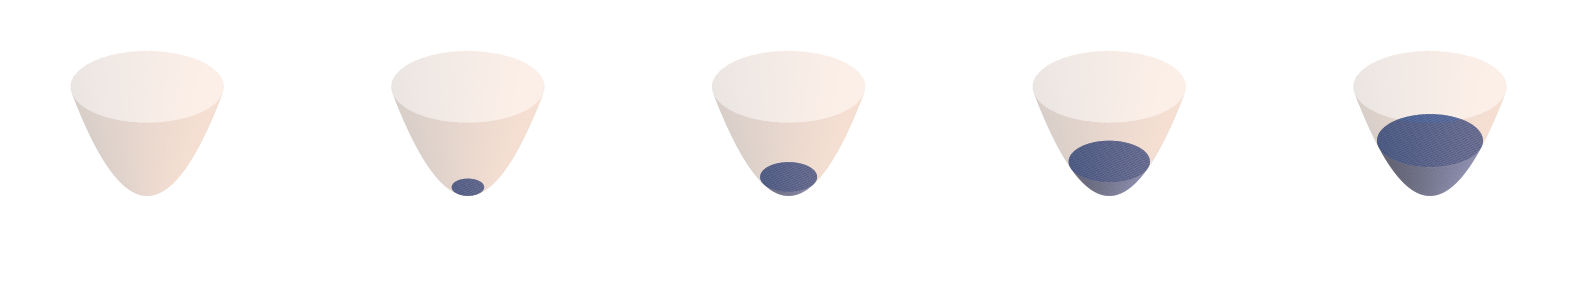

In [101]:
ZLIMS = [0.0001, 0.05, 0.15, 0.3, 0.5]

def U_paraboloid(x):
    return x[0]**2 + x[1]**2 

plot_U_volume_growth(U_paraboloid, ZLIMS)

(<Figure size 2000x1000 with 5 Axes>,
 array([<Axes3D: >, <Axes3D: >, <Axes3D: >, <Axes3D: >, <Axes3D: >],
       dtype=object))

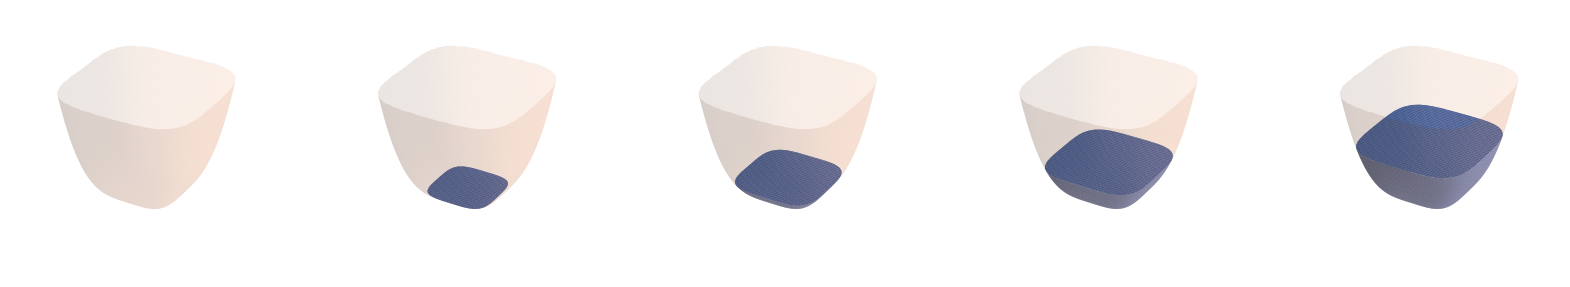

In [102]:
def U_quartic(x):
    return x[0]**4 + x[1]**4

plot_U_volume_growth(U_quartic, ZLIMS)

(<Figure size 2000x1000 with 5 Axes>,
 array([<Axes3D: >, <Axes3D: >, <Axes3D: >, <Axes3D: >, <Axes3D: >],
       dtype=object))

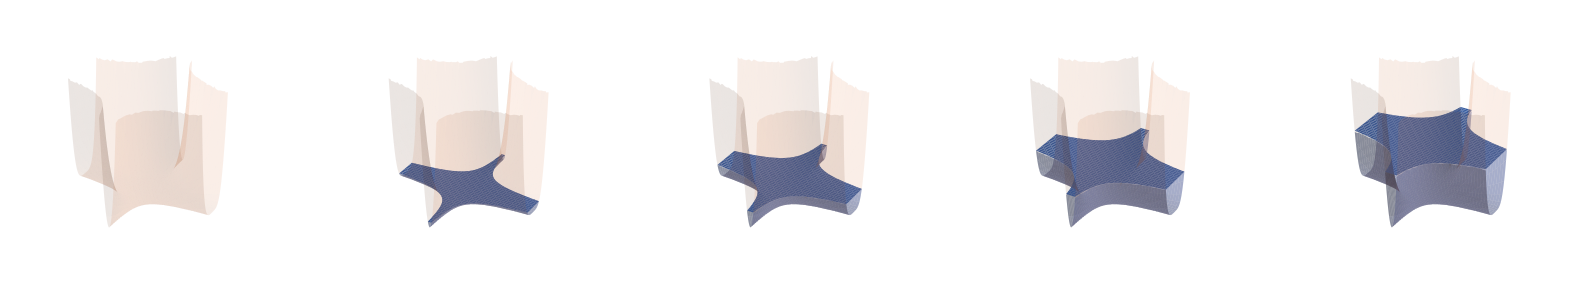

In [200]:
def U_valleys(x):
    return x[0]**2 * x[1]**2

def U_valleys_2(x):
    return x[0]**2 * x[1]**4


plot_U_volume_growth(U_valleys_2, ZLIMS, xlim=(-2, 2), ylim=(-2, 2))

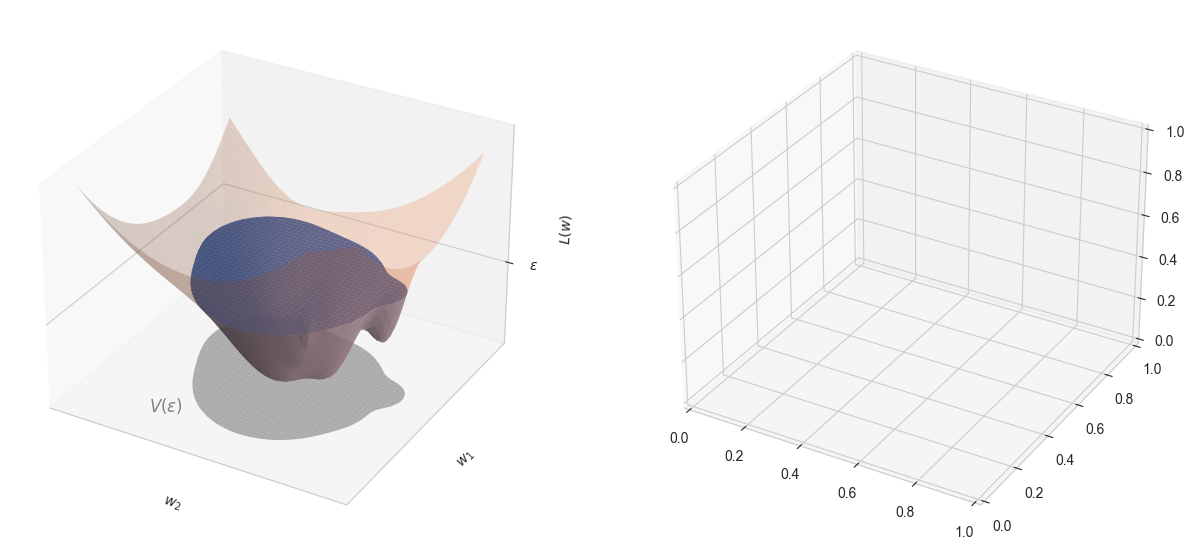

In [238]:
# Toy landscape

def make_U_fakir_bed(k: int, sigma: int, lim=(-1, 1)):
    """
    k is the number of bumps. sigma is the std for sampling the width of the bumps.
    """
    components = []

    for i in range(k):
        center = np.random.uniform(*lim, size=2)
        width = np.random.normal(0, sigma)
        components.append(lambda x, center=center, width=width: np.exp(-np.linalg.norm(x - center)**2 / width**2))

    def U_fakir_bed(x):
        return -np.log(np.sum([c(x) for c in components]))
    
    return U_fakir_bed

np.random.seed(0)
U_fakir_bed = make_U_fakir_bed(10, 0.75, lim=(-1.25, 1.25))
fig, axes = plt.subplots(1, 2, figsize=(15, 10), subplot_kw={'projection': '3d'})
ax = axes[0]

ZLIM = 0.5

plot_U_3D_cap(lambda x: -1+U_fakir_bed(x) + 0.001, zlim=-1+ZLIM, xlim=(-2, 2), ylim=(-2, 2), linewidth=0, color="gray", alpha=0.5, ax=ax)
plot_U_3D_covered(lambda x: 1+U_fakir_bed(x) + 0.001, zlim=1+ZLIM, xlim=(-2, 2), ylim=(-2, 2), linewidth=0, color=PRIMARY, bulk_alpha=0.5, ax=ax)
plot_U_3D(lambda x: 1+U_fakir_bed(x), zlim=4, xlim=(-2, 2), ylim=(-2, 2), linewidth=0, color=SECONDARY, alpha=0.25, ax=ax)

ax.set_yticks([])
ax.set_xticks([])
ax.set_zticks([1+ZLIM])
ax.set_zticklabels([r"$\epsilon$"])
ax.set_ylabel("$w_1$")
ax.set_xlabel("$w_2$")
ax.set_zlabel("$L(w)$")
# ax.text(-1.25, -1, -1 + ZLIM, r"$L(w)$", fontsize=12, color="gray", ha='center', va='center')
# ax.text(2, 1, ZLIM, r"$L(w)<\epsilon$", fontsize=12, color=PRIMARY, ha='center', va='center')
ax.text(-1.25, -1, -1 + ZLIM, r"$V(\epsilon)$", fontsize=12, color="gray", ha='center', va='center')
# ax.set_zlabel(r"$L(\mathbf{w})$")
ax.set_title("") 

plt.savefig("fakir_bed.png", bbox_inches='tight', dpi=300)

# Change color of the axis plane
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# Hide the lines
# ax.xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

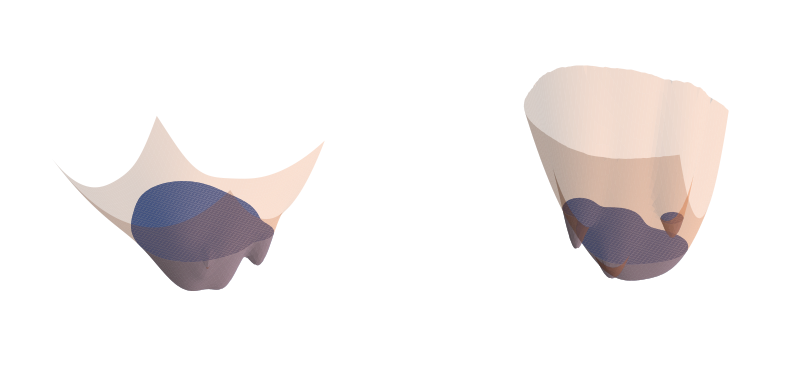

In [127]:
# Basin broadness comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 10), subplot_kw={'projection': '3d'})

for i, ax in zip(range(2), axes):
    np.random.seed(i)
    U_fakir_bed = make_U_fakir_bed(10, 0.75, lim=(-1.25, 1.25))
    plot_U_3D_covered(lambda x: U_fakir_bed(x) + 0.001, zlim=ZLIM, xlim=(-2, 2), ylim=(-2, 2), linewidth=0, color=PRIMARY, bulk_alpha=0.5, ax=ax)
    plot_U_3D(U_fakir_bed, zlim=4, xlim=(-2, 2), ylim=(-2, 2), linewidth=0, color=SECONDARY, alpha=0.25, ax=ax)
    isolate_contour(ax)

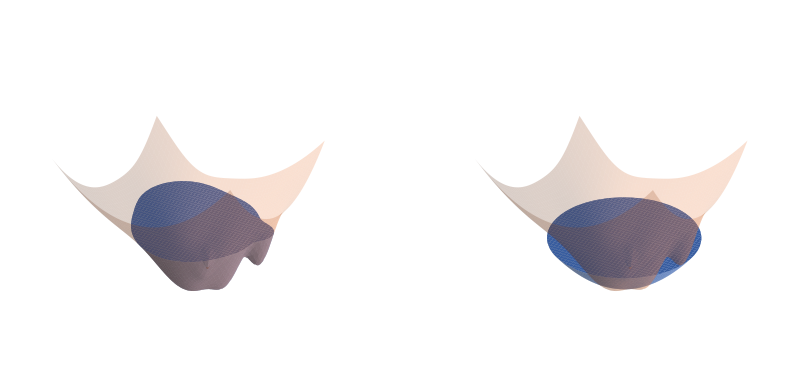

In [143]:
# Paraboloid approximation

fig, axes = plt.subplots(1, 2, figsize=(10, 10), subplot_kw={'projection': '3d'})

ax1, ax2 = axes

np.random.seed(0)
U_fakir_bed = make_U_fakir_bed(10, 0.75, lim=(-1.25, 1.25))
plot_U_3D_covered(lambda x: U_fakir_bed(x) + 0.001, zlim=ZLIM, xlim=(-2, 2), ylim=(-2, 2), linewidth=0, color=PRIMARY, bulk_alpha=0.5, ax=ax1)
plot_U_3D(U_fakir_bed, zlim=4, xlim=(-2, 2), ylim=(-2, 2), linewidth=0, color=SECONDARY, alpha=0.25, ax=ax1)
isolate_contour(ax1)

def U_fakir_bed_approx(x):
    # Hand-picked for the seed=0 potential
    return 0.5 * ((x[0]-0.25)**2 + (x[1])**2) - .75

plot_U_3D_covered(U_fakir_bed_approx, zlim=ZLIM, xlim=(-2, 2), ylim=(-2, 2), linewidth=0, color=PRIMARY, bulk_alpha=0.5, ax=ax2)
plot_U_3D(U_fakir_bed, zlim=4, xlim=(-2, 2), ylim=(-2, 2), linewidth=0, color=SECONDARY, alpha=0.25, ax=ax2)
ax2.set_zlim(0, 4)

isolate_contour(ax2)

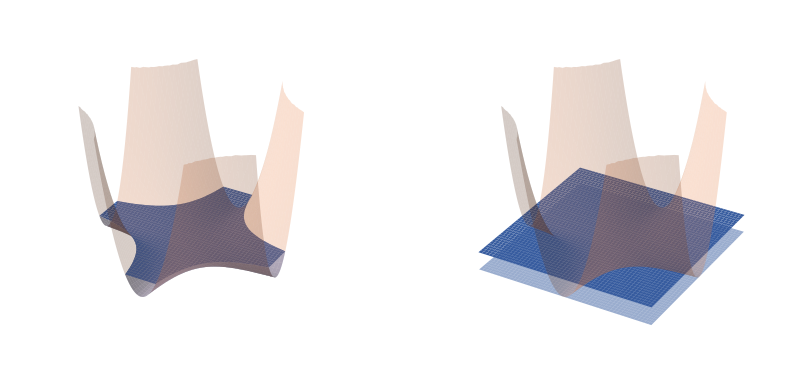

In [382]:
# Singular models mess shit up.
fig, axes = plt.subplots(1, 2, figsize=(10, 10), subplot_kw={'projection': '3d'})

ax1, ax2 = axes

plot_U_3D_covered(lambda x: U_valleys(x) + 0.001, zlim=ZLIM, xlim=(-2, 2), ylim=(-2, 2), linewidth=0, color=PRIMARY, bulk_alpha=0.5, ax=ax1)
plot_U_3D(U_valleys, zlim=4, xlim=(-2, 2), ylim=(-2, 2), linewidth=0, color=SECONDARY, alpha=0.25, ax=ax1)
isolate_contour(ax1)

def U_valleys_approx(x):
    # Hand-picked for the seed=0 potential
    return 0.0001 * ((x[0]-0.25)**2 + (x[1])**2)

plot_U_3D_covered(U_valleys_approx, zlim=ZLIM, xlim=(-2, 2), ylim=(-2, 2), linewidth=0, color=PRIMARY, bulk_alpha=0.5, ax=ax2)
plot_U_3D(U_valleys, zlim=4, xlim=(-2, 2), ylim=(-2, 2), linewidth=0, color=SECONDARY, alpha=0.25, ax=ax2)
ax2.set_zlim(0, 4)

isolate_contour(ax2)

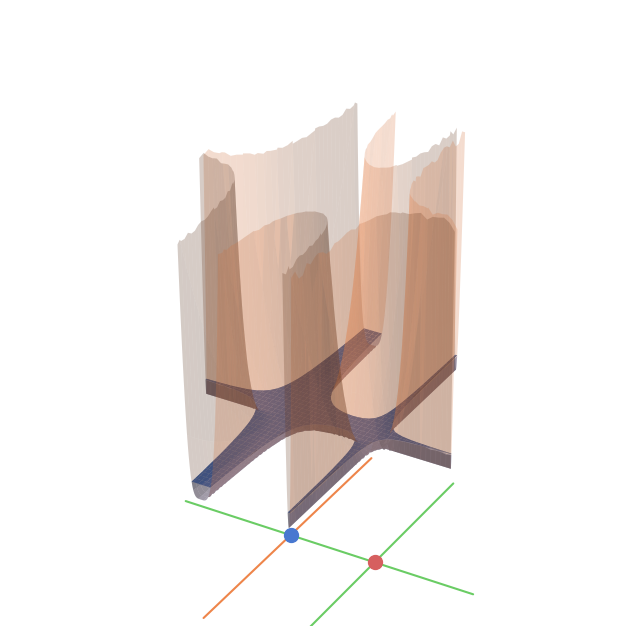

In [222]:
def U_multiple_valleys(x):
    return 0.25 * (x[0]+1.5) ** 4 * (x[0]-2) ** 2 * x[1] ** 2

fig, ax = plt.subplots(1, 1, figsize=(15, 8), subplot_kw={'projection': '3d'})

# Define the PRIMARY, SECONDARY, and TERTIARY lines
x1 = -1.5
y1 = np.linspace(-2, 2, 100)
x2 = 2
y2 = np.linspace(-2, 2, 100)
x3 = np.array([-6, 6])
y3 = np.array([0, 0])
z = -2

# Create a 3D plot
ax.plot(x1 * np.ones_like(y1), y1, z * np.ones_like(y1), color=SECONDARY, zorder=-1)
ax.plot(x2 * np.ones_like(y2), y2, z * np.ones_like(y2),  color=TERTIARY, zorder=-1)
ax.plot(x3, y3, z * np.ones_like(x3), color=TERTIARY, zorder=-1)

# Plot points at x, y = -1.5, 0 and 2, 0
ax.scatter(-1.5, 0, z, color=PRIMARY, s=100, zorder=10)
ax.scatter(2, 0, z, color=CMAP[3], s=100)


plot_U_3D_covered(lambda x: U_multiple_valleys(x) + 0.001, zlim=0.25, xlim=(-5, 5), ylim=(-2, 2), linewidth=0, color=PRIMARY, bulk_alpha=0.5, ax=ax, num_points=(3_000, 5_000))
plot_U_3D(U_multiple_valleys, zlim=4, xlim=(-5, 5), ylim=(-2, 2), linewidth=0, color=SECONDARY, alpha=0.25, ax=ax, num_points=(3_000, 5_000))

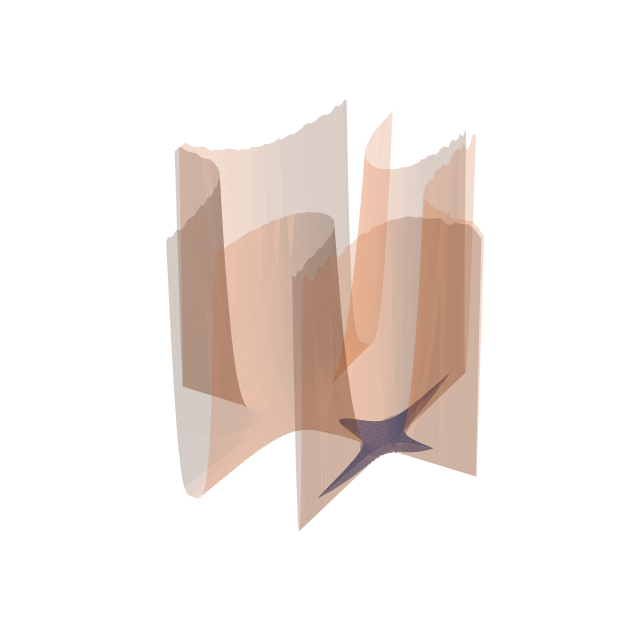

In [294]:
def U_paraboloid_at_2(x):
    return (x[0]-2)**2 + x[1]**2 

def U_multiple_valleys_with_localizing_prior(x):
    return U_multiple_valleys(x) + 0.1 * U_paraboloid_at_2(x) 

fig, ax = plt.subplots(1, 1, figsize=(15, 8), subplot_kw={'projection': '3d'})

plot_U_3D(lambda x: U_paraboloid_at_2(x) + 0.001, zlim=0.25, xlim=(-5, 5), ylim=(-2, 2), linewidth=0, color=PRIMARY, alpha=0.25, ax=ax, num_points=(2_000, 2_000))
plot_U_3D_cap(lambda x: U_paraboloid_at_2(x) + 0.001, zlim=0.25, xlim=(-5, 5), ylim=(-2, 2), linewidth=0, color=PRIMARY, alpha=0.25, ax=ax, num_points=(2_000, 2_000))
plot_U_3D_covered(lambda x: U_multiple_valleys_with_localizing_prior(x) + 0.001, zlim=0.25, xlim=(-5, 5), ylim=(-2, 2), linewidth=0, color=PRIMARY, bulk_alpha=0.5, ax=ax, num_points=(2_000, 2_000))
plot_U_3D(U_multiple_valleys, zlim=4, xlim=(-5, 5), ylim=(-2, 2), linewidth=0, color=SECONDARY, alpha=0.25, ax=ax, num_points=(3_000, 5_000))
isolate_contour(ax)

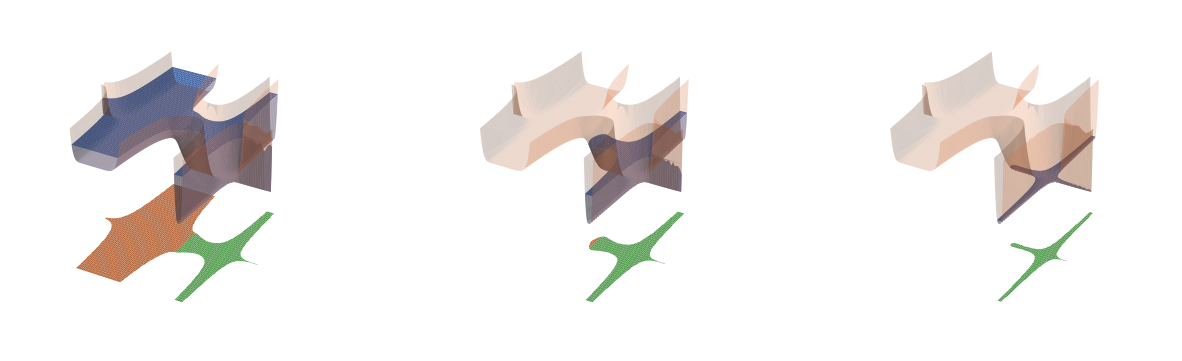

In [381]:
# def quartic(x, e = 1):
#     return (1 - 0.5) * x ** 4 + 0.25 * x ** 3 + (1 - 2 * e) *  x ** 2 - 0.75 * x + e

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def normal(x):
    return np.exp(-np.sum(x**2) / 2) / np.sqrt(2 * np.pi)

def U_waterfall(x):
    # return 2 * quartic(x[0]) * (x[1] ** 4)
    return 5 * (x[0]+1) ** 10 * (x[0]-1) ** 4 * (x[1]) ** 2 + 1 + 0.5 * np.tanh(-10 * x[0]) # + 0.25 * (1 + np.tanh(100_000 * (x[1]-0.5))) * (x[0]<0) # + 0.5 * normal(10_000 * x[1])

fig, axes = plt.subplots(1, 3, figsize=(15, 8), subplot_kw={'projection': '3d'})

RESOLUTION_1 = 3_00
RESOLUTION_2 = 10_000

for ax, zlim in zip(axes, [2, 1.4, 0.6]):
    plot_U_3D_cap(lambda x: U_waterfall(x) + -2 - zlim, zlim=-2, xlim=(-2, 0), ylim=(-2, 2), linewidth=0, color=SECONDARY, ax=ax, num_points=(RESOLUTION_1//2, RESOLUTION_1))
    plot_U_3D_cap(lambda x: U_waterfall(x) + -2 - zlim, zlim=-2, xlim=(0, 2), ylim=(-2, 2), linewidth=0, color=TERTIARY, ax=ax, num_points=(RESOLUTION_1//2, RESOLUTION_1))
    plot_U_3D_covered(lambda x: U_waterfall(x) + 0.001, zlim=zlim, xlim=(-2, 0), ylim=(-2, 2), linewidth=0, color=PRIMARY, bulk_alpha=0.5, ax=ax, num_points=(RESOLUTION_2//2, RESOLUTION_2))
    plot_U_3D_covered(lambda x: U_waterfall(x) + 0.001, zlim=zlim, xlim=(0, 2), ylim=(-2, 2), linewidth=0, color=PRIMARY, bulk_alpha=0.5, ax=ax, num_points=(RESOLUTION_2//2, RESOLUTION_2))
    plot_U_3D(U_waterfall, zlim=2.5, xlim=(-2, 2), ylim=(-2, 2), linewidth=0, color=SECONDARY, alpha=0.25, ax=ax, num_points=RESOLUTION_2)
    ax.set_zlim(-2, 2.5)
    isolate_contour(ax)

plt.savefig("waterfall.png", bbox_inches='tight', dpi=300, transparent=True, facecolor='none')

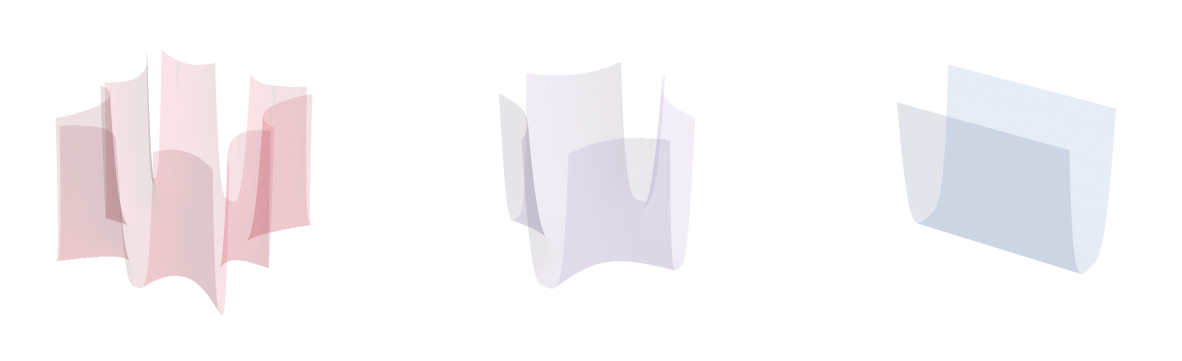

In [293]:
def U_valleys_3(x):
    return 2 * x[0]**4 * x[1]**2 * (x[0] - x[1])**4 * (x[0] + x[1])**4

def U_valleys_4(x):
    return 0.75 * x[0]**4 * (x[1]) ** 4 

def U_valleys_5(x):
    return x[1]**4


fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': '3d'})

KWARGS = {"xlim": (-2, 2), "ylim": (-2, 2)}
plot_U_3D(U_valleys_3, ax=axes[0], zlim=1., linewidth=0., alpha=0.125, color="#E8243C", num_points=9000, xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))
plot_U_3D(U_valleys_4, ax=axes[1], zlim=1., linewidth=0., alpha=0.125, color="#AA80D7", num_points=4000, **KWARGS)
plot_U_3D(U_valleys_5, ax=axes[2], zlim=1., linewidth=0., alpha=0.125, color="#407CD7", num_points=4000, **KWARGS)
isolate_contour(axes[0])
isolate_contour(axes[1])
isolate_contour(axes[2])

plt.savefig('singularities.png', transparent=True, facecolor='none')